In [1]:
%matplotlib inline


Transfer Learning Tutorial
==========================
**Author**: `Sasank Chilamkurthy <https://chsasank.github.io>`_

In this tutorial, you will learn how to train your network using
transfer learning. You can read more about the transfer learning at `cs231n
notes <https://cs231n.github.io/transfer-learning/>`__

Quoting these notes,

    In practice, very few people train an entire Convolutional Network
    from scratch (with random initialization), because it is relatively
    rare to have a dataset of sufficient size. Instead, it is common to
    pretrain a ConvNet on a very large dataset (e.g. ImageNet, which
    contains 1.2 million images with 1000 categories), and then use the
    ConvNet either as an initialization or a fixed feature extractor for
    the task of interest.

These two major transfer learning scenarios look as follows:

-  **Finetuning the convnet**: Instead of random initializaion, we
   initialize the network with a pretrained network, like the one that is
   trained on imagenet 1000 dataset. Rest of the training looks as
   usual.
-  **ConvNet as fixed feature extractor**: Here, we will freeze the weights
   for all of the network except that of the final fully connected
   layer. This last fully connected layer is replaced with a new one
   with random weights and only this layer is trained.




In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from sklearn import metrics
from sklearn.metrics import roc_auc_score
import scikitplot as skplt
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

Load Data
---------

We will use torchvision and torch.utils.data packages for loading the
data.

The problem we're going to solve today is to train a model to classify
**adenomas** and **non-neoplastics**. We have about 125 training images each for adenomas and non-neoplastic.
There are 75 validation images for each class. Usually, this is a very
small dataset to generalize upon, if trained from scratch. Since we
are using transfer learning, we should be able to generalize reasonably
well.


In [3]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
}

data_dir = 'data/pituitary_data_gray'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val', 'test']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Visualize a few images
^^^^^^^^^^^^^^^^^^^^^^
Let's visualize a few training images so as to understand the data
augmentations.



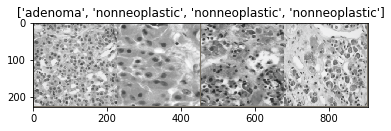

In [4]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

Training the model
------------------

Now, let's write a general function to train a model. Here, we will
illustrate:

-  Scheduling the learning rate
-  Saving the best model

In the following, parameter ``scheduler`` is an LR scheduler object from
``torch.optim.lr_scheduler``.



Visualizing the model predictions
^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^

Generic function to display predictions for a few images




In [5]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    train_val_losses = {'train': [],
                        'val': []
                       }
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # Zero the parameter gradients
                optimizer.zero_grad()

                # Forward
                # Track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # Backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # Add information to loss dictionary
            train_val_losses[phase].append(epoch_loss)

            # Deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

    # Training outcomes and metrics
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))
    plot_learning_curve(train_val_losses.get('train'), train_val_losses.get('val'), num_epochs)

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [6]:
# Plot the learning curve during training and validation

def plot_learning_curve(training_loss, validation_loss, num_epoch):

    # Initialize and form plot
    epoch_array = range(0, num_epoch)
    plt.figure()
    plt.plot(epoch_array, training_loss, 'b', label = 'Training loss')
    plt.legend(loc = 'lower right')
    plt.plot(epoch_array, validation_loss, 'r', label = 'Validation loss')

    plt.xlim([0, num_epoch])
    plt.ylim([0, 1])

    plt.xlabel('Epoch')
    plt.ylabel('Loss')

    plt.title('Training/Validation Loss over Time')
    plt.legend(loc = "lower right")
    plt.show()
    plt.savefig('Training_Validation.jpg')

In [7]:
def compute_roc_metrics(groundtruth_labels, probs):

    # Compute ROC AUC Score
    true_labels = np.array(groundtruth_labels) # Numpy array of binary class for each tested image
    prob_scores = np.array(probs) # Numpy array of confidence percentages of each tested image
    auc_roc = roc_auc_score(true_labels, prob_scores)
    print('Computed ROC AUC Score: {}'.format(auc_roc))

    # Compute true and false positive rates
    fpr, tpr, thresholds = metrics.roc_curve(true_labels, prob_scores)
    print('False positive rate: {}'.format(fpr))
    print('True positive rate: {}'.format(tpr))

    # Plot computed metrics
    plt.figure()
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_roc)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')

    plt.xlim([0, 1])
    plt.ylim([0, 1])

    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')

    plt.title('Receiver Operating Characteristic')
    plt.legend(loc = "lower right")
    plt.show()
    plt.savefig('ROC.jpg')

In [8]:
def visualize_model(model, num_images=40):
    was_training = model.training
    model.eval()
    images_so_far = 0
    total = 0
    correct = 0
    probability = 0
    fig = plt.figure()
    prob_estimates = [] # Percentage values for predictions
    pred_estimates = [] # Binary class predictions
    pred_groundtruth = [] # Groundtruth labels

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//4, 4, images_so_far)
                ax.axis('off')
                ax.set_title('Predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                # Model statistics
                total += labels.size(0)
                correct += (preds == labels).sum().item()
                probability = 100 * correct / total
                prob_estimates.append(probability)
                pred_estimates.append(preds[j].item())
                pred_groundtruth.append(labels[j].item())

                print('Accuracy of the network on test image: %d %%' % (
                    probability))

                # Stop testing images
                if images_so_far == num_images:
                    model.train(mode=was_training)

                    # Print array data
                    print('Groundtruth labels: {}'.format(pred_groundtruth))
                    print('Predicted labels: {}'.format(pred_estimates))
                    print('Confidence of predictions: {}'.format(prob_estimates))
                    compute_roc_metrics(pred_groundtruth, prob_estimates)
                    return

        model.train(mode=was_training)


Finetuning the convnet
----------------------

Load a pretrained model and reset final fully connected layer.




In [9]:
model_ft = models.resnet18(pretrained=False)
num_ftrs = model_ft.fc.in_features
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

It should take around 15-25 min on CPU. On GPU though, it takes less than a
minute.




Epoch 0/24
----------
train Loss: 0.6796 Acc: 0.6071
val Loss: 0.3161 Acc: 0.8250
Epoch 1/24
----------
train Loss: 0.6011 Acc: 0.7429
val Loss: 0.3456 Acc: 0.7500
Epoch 2/24
----------
train Loss: 0.5104 Acc: 0.7750
val Loss: 0.1520 Acc: 0.9750
Epoch 3/24
----------
train Loss: 0.4563 Acc: 0.7964
val Loss: 0.1131 Acc: 0.9750
Epoch 4/24
----------
train Loss: 0.3661 Acc: 0.8571
val Loss: 0.1310 Acc: 0.9750
Epoch 5/24
----------
train Loss: 0.4341 Acc: 0.8500
val Loss: 0.1673 Acc: 0.9750
Epoch 6/24
----------
train Loss: 0.4907 Acc: 0.7857
val Loss: 0.4475 Acc: 0.7750
Epoch 7/24
----------
train Loss: 0.4487 Acc: 0.8500
val Loss: 0.0780 Acc: 0.9750
Epoch 8/24
----------
train Loss: 0.3373 Acc: 0.8500
val Loss: 0.1638 Acc: 0.9250
Epoch 9/24
----------
train Loss: 0.4174 Acc: 0.8464
val Loss: 0.1484 Acc: 0.9250
Epoch 10/24
----------
train Loss: 0.3656 Acc: 0.8393
val Loss: 0.1540 Acc: 0.9750
Epoch 11/24
----------
train Loss: 0.3296 Acc: 0.8536
val Loss: 0.1386 Acc: 0.9750
Epoch 12/24
--

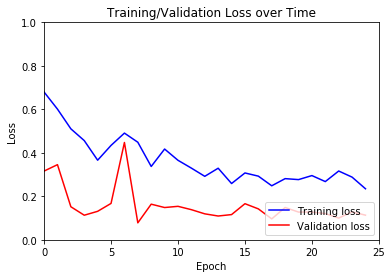

<Figure size 432x288 with 0 Axes>

In [10]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)

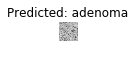

Accuracy of the network on test image: 50 %


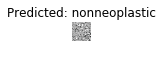

Accuracy of the network on test image: 50 %


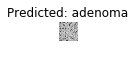

Accuracy of the network on test image: 50 %


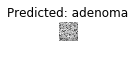

Accuracy of the network on test image: 50 %


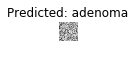

Accuracy of the network on test image: 60 %


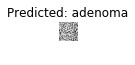

Accuracy of the network on test image: 66 %


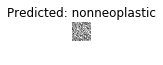

Accuracy of the network on test image: 71 %


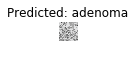

Accuracy of the network on test image: 75 %


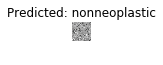

Accuracy of the network on test image: 77 %


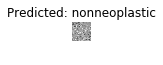

Accuracy of the network on test image: 80 %


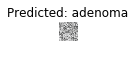

Accuracy of the network on test image: 81 %


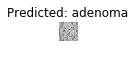

Accuracy of the network on test image: 83 %


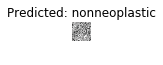

Accuracy of the network on test image: 84 %


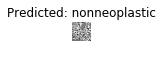

Accuracy of the network on test image: 85 %


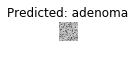

Accuracy of the network on test image: 86 %


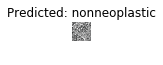

Accuracy of the network on test image: 87 %


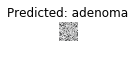

Accuracy of the network on test image: 85 %


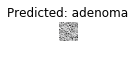

Accuracy of the network on test image: 83 %


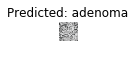

Accuracy of the network on test image: 81 %


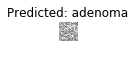

Accuracy of the network on test image: 80 %


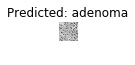

Accuracy of the network on test image: 80 %


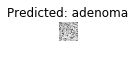

Accuracy of the network on test image: 81 %


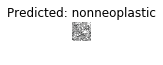

Accuracy of the network on test image: 82 %


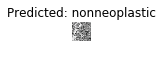

Accuracy of the network on test image: 83 %


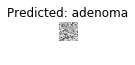

Accuracy of the network on test image: 84 %


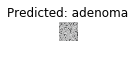

Accuracy of the network on test image: 84 %


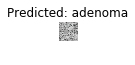

Accuracy of the network on test image: 85 %


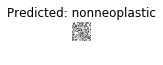

Accuracy of the network on test image: 85 %


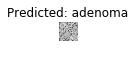

Accuracy of the network on test image: 86 %


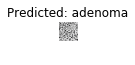

Accuracy of the network on test image: 86 %


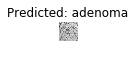

Accuracy of the network on test image: 87 %


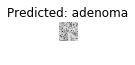

Accuracy of the network on test image: 87 %


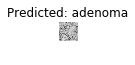

Accuracy of the network on test image: 87 %


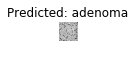

Accuracy of the network on test image: 88 %


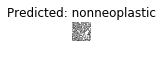

Accuracy of the network on test image: 88 %


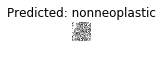

Accuracy of the network on test image: 88 %


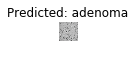

Accuracy of the network on test image: 89 %


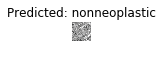

Accuracy of the network on test image: 89 %


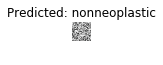

Accuracy of the network on test image: 89 %


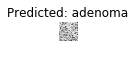

Accuracy of the network on test image: 90 %
Groundtruth labels: [0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
Predicted labels: [0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0]
Confidence of predictions: [50.0, 50.0, 50.0, 50.0, 60.0, 66.66666666666667, 71.42857142857143, 75.0, 77.77777777777777, 80.0, 81.81818181818181, 83.33333333333333, 84.61538461538461, 85.71428571428571, 86.66666666666667, 87.5, 85.29411764705883, 83.33333333333333, 81.57894736842105, 80.0, 80.95238095238095, 81.81818181818181, 82.6086956521739, 83.33333333333333, 84.0, 84.61538461538461, 85.18518518518519, 85.71428571428571, 86.20689655172414, 86.66666666666667, 87.09677419354838, 87.5, 87.87878787878788, 88.23529411764706, 88.57142857142857, 88.88888888888889, 89.1891891891892, 89.47368421052632, 89.74358974358974, 90.0]
Computed ROC AUC Score: 0.44823232323232326
Fa

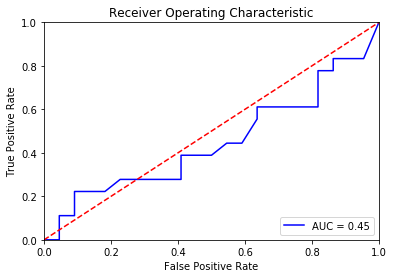

<Figure size 432x288 with 0 Axes>

In [11]:
visualize_model(model_ft)

ConvNet as fixed feature extractor
----------------------------------

Here, we need to freeze all the network except the final layer. We need
to set ``requires_grad == False`` to freeze the parameters so that the
gradients are not computed in ``backward()``.

You can read more about this in the documentation
`here <https://pytorch.org/docs/notes/autograd.html#excluding-subgraphs-from-backward>`__.




In [12]:
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)

Train and evaluate
^^^^^^^^^^^^^^^^^^

On CPU this will take about half the time compared to previous scenario.
This is expected as gradients don't need to be computed for most of the
network. However, forward does need to be computed.




Epoch 0/24
----------
train Loss: 0.6482 Acc: 0.6679
val Loss: 0.4401 Acc: 0.7500
Epoch 1/24
----------
train Loss: 0.4377 Acc: 0.7821
val Loss: 0.3312 Acc: 0.8000
Epoch 2/24
----------
train Loss: 0.5274 Acc: 0.7536
val Loss: 0.1021 Acc: 0.9750
Epoch 3/24
----------
train Loss: 0.4213 Acc: 0.8429
val Loss: 0.0894 Acc: 0.9750
Epoch 4/24
----------
train Loss: 0.4137 Acc: 0.8179
val Loss: 0.0831 Acc: 1.0000
Epoch 5/24
----------
train Loss: 0.6147 Acc: 0.7714
val Loss: 0.1566 Acc: 0.9250
Epoch 6/24
----------
train Loss: 0.5386 Acc: 0.7857
val Loss: 0.2936 Acc: 0.9000
Epoch 7/24
----------
train Loss: 0.3886 Acc: 0.8500
val Loss: 0.0793 Acc: 0.9500
Epoch 8/24
----------
train Loss: 0.3110 Acc: 0.8679
val Loss: 0.0879 Acc: 0.9500
Epoch 9/24
----------
train Loss: 0.2971 Acc: 0.8714
val Loss: 0.0942 Acc: 0.9500
Epoch 10/24
----------
train Loss: 0.2796 Acc: 0.8857
val Loss: 0.0961 Acc: 0.9750
Epoch 11/24
----------
train Loss: 0.3139 Acc: 0.8607
val Loss: 0.0934 Acc: 0.9500
Epoch 12/24
--

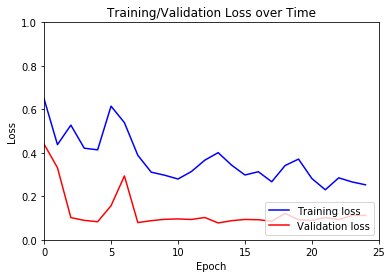

<Figure size 432x288 with 0 Axes>

In [13]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)

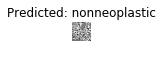

Accuracy of the network on test image: 75 %


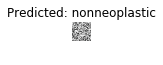

Accuracy of the network on test image: 75 %


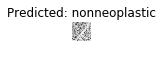

Accuracy of the network on test image: 75 %


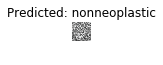

Accuracy of the network on test image: 75 %


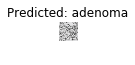

Accuracy of the network on test image: 80 %


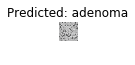

Accuracy of the network on test image: 83 %


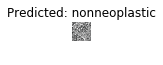

Accuracy of the network on test image: 85 %


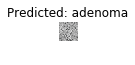

Accuracy of the network on test image: 87 %


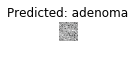

Accuracy of the network on test image: 86 %


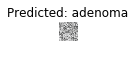

Accuracy of the network on test image: 85 %


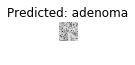

Accuracy of the network on test image: 84 %


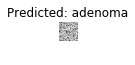

Accuracy of the network on test image: 83 %


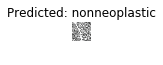

Accuracy of the network on test image: 84 %


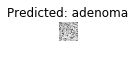

Accuracy of the network on test image: 85 %


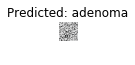

Accuracy of the network on test image: 86 %


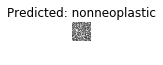

Accuracy of the network on test image: 87 %


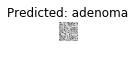

Accuracy of the network on test image: 88 %


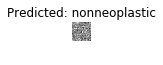

Accuracy of the network on test image: 88 %


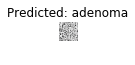

Accuracy of the network on test image: 89 %


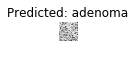

Accuracy of the network on test image: 90 %


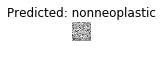

Accuracy of the network on test image: 90 %


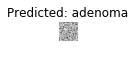

Accuracy of the network on test image: 90 %


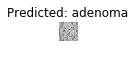

Accuracy of the network on test image: 91 %


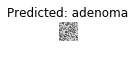

Accuracy of the network on test image: 91 %


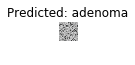

Accuracy of the network on test image: 91 %


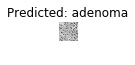

Accuracy of the network on test image: 90 %


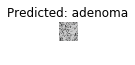

Accuracy of the network on test image: 89 %


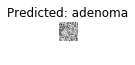

Accuracy of the network on test image: 89 %


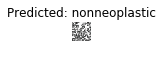

Accuracy of the network on test image: 89 %


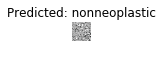

Accuracy of the network on test image: 90 %


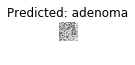

Accuracy of the network on test image: 90 %


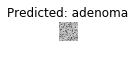

Accuracy of the network on test image: 90 %


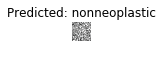

Accuracy of the network on test image: 90 %


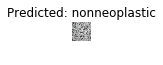

Accuracy of the network on test image: 91 %


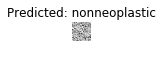

Accuracy of the network on test image: 91 %


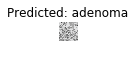

Accuracy of the network on test image: 91 %


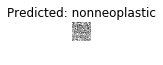

Accuracy of the network on test image: 91 %


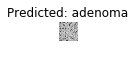

Accuracy of the network on test image: 90 %


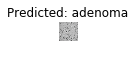

Accuracy of the network on test image: 90 %


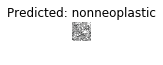

Accuracy of the network on test image: 90 %
Groundtruth labels: [1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1]
Predicted labels: [1, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1]
Confidence of predictions: [75.0, 75.0, 75.0, 75.0, 80.0, 83.33333333333333, 85.71428571428571, 87.5, 86.11111111111111, 85.0, 84.0909090909091, 83.33333333333333, 84.61538461538461, 85.71428571428571, 86.66666666666667, 87.5, 88.23529411764706, 88.88888888888889, 89.47368421052632, 90.0, 90.47619047619048, 90.9090909090909, 91.30434782608695, 91.66666666666667, 91.0, 90.38461538461539, 89.81481481481481, 89.28571428571429, 89.65517241379311, 90.0, 90.3225806451613, 90.625, 90.9090909090909, 91.17647058823529, 91.42857142857143, 91.66666666666667, 91.21621621621621, 90.78947368421052, 90.38461538461539, 90.0]
Computed ROC AUC Score: 0.5252525252525253
False positive r

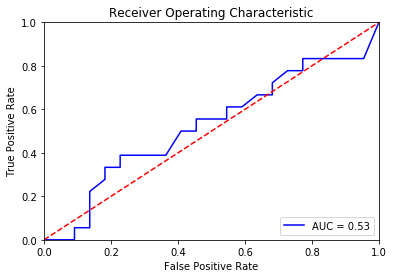

<Figure size 432x288 with 0 Axes>

In [16]:
visualize_model(model_conv)

plt.ioff()
plt.show()